In [1]:
# download mnist data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
print('X.shape >> {}\ny.shape >> {}'.format(X.shape, y.shape))

X.shape >> (70000, 784)
y.shape >> (70000,)


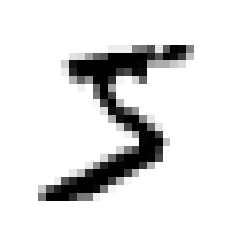

value of some_digit is 5


In [3]:
# mnist data to image
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_to_image = some_digit.reshape(28,28)

plt.imshow(some_digit_to_image, cmap='binary')
plt.axis('off')
plt.show()
print('value of some_digit is {}'.format(y[0]))

In [4]:
# change integer because label is string

import numpy as np
print('before >> ',type(y[0]))
y = y.astype(np.uint8)
print('after >> ',type(y[0]))

before >>  <class 'str'>
after >>  <class 'numpy.uint8'>


In [5]:
# split train set, test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [6]:
# binary classification
# class {5, not 5}
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [7]:
# Stichastic Gradient Descent classifier to binary classification
# this model have pros : efficient processing of very large dataset
#     - because, SGD handled one training sample at a time
#       (so, SGD is suit at online learning)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# predict upside digit(5)
# result give True it means it is 5
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# measure perfomance
# measure accuracy by cross validation
# below code return same result of sklearn's cross_val_score function

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_idx, test_idx in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [10]:
# k-fold cross validation(k=3) sgdclassifier evaluation
# accuracy is over than 0.95
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# below model return False about any image

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [12]:
# accuracy is over than 0.9 because in data, only 10% image is 5 
# this example show accuracy is not prefer to classifer performance evaluation index
# especially in imbalanced data

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [13]:
# better method of evaluation classifer performance, using confusion matrix
# we use sklearn cross_val_predict
# cross_val_oredict function do k-fold cross validation but it doesn't return evaluation score
# it returns prediction of each test fold
# in other words, we can prediction of data on each train set

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
# we use confusion_matrix function of sklearn
# row means real data and col means predict data
# in this case, negative class is not 5(in below result first row)
# then 53892 means true negative(true=negative, pred=negative)
# 687 means false positive(true=negative, pred=positive)
# and second row is positive class(is 5), 1891 means false negative(true=positive, pred=negative)
# 3530 means true positive(true=positive, pred=positive)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
# if perfect model then we get confusion matrix like below
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [16]:
# precision means true positive rate per positive in predict data
# if perfect model then we get precision=1
# recall means true positive rate per positive in true data (it calls sensitivity or TPR(true positive rate))
# if perfect model then we get recall=1
# we can use precision_score, recall_score in sklearn
# below means it is not good

from sklearn.metrics import precision_score, recall_score

print('precision >> ',precision_score(y_train_5, y_train_pred))

print('recall >> ', recall_score(y_train_5, y_train_pred))

precision >>  0.8370879772350012
recall >>  0.6511713705958311


In [17]:
# if precision and recall into one number which called F1 score, it is comfortable 
# f1 score is harmonic mean of precision and recall
# we can use f1_score in sklearn
# in classificater which have similar precision, recall then that model get high f1 score
# but it is not always good because depending on the situation, precision,recall are important or not
# the best is high recall and high precision but unfortunately we can't get at the same time
# we call precision/recall trade off, it means if we increase precision then recall is reduce. it same another.
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
# precision/recall trade off
# during take a look how SGDClassifier decide classification, we understand this trade off.
# this classifier calculate each sample score by decision function
# if this score is bigger than threshold then positive else negative
# we can't set threshold but we can get score to predict
# that function is decision_function()

y_scores = sgd_clf.decision_function([some_digit])
print('5 score is >> ',y_scores)
threshold=0
y_some_digit_pred = (y_scores>threshold)
print(y_some_digit_pred)

5 score is >>  [2164.22030239]
[ True]


In [19]:
# in case we set threshold higher then we get another result
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
print(y_some_digit_pred)

[False]


In [20]:
# then how can we get appropriate threshold?
# first of all we have to get all of train set's score by cross_val_predict function
# but we have to recieve decision score, not predict result
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [21]:
# by above scores we can calculate precision,recall about all of threshold

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

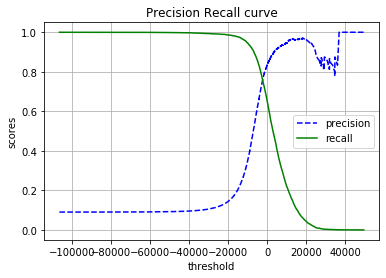

In [22]:
# now we can precision,recall graph using matplotlib
%matplotlib inline
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.title('Precision Recall curve')
    plt.xlabel('threshold')
    plt.ylabel('scores')
    plt.legend(loc='right')
    plt.grid()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

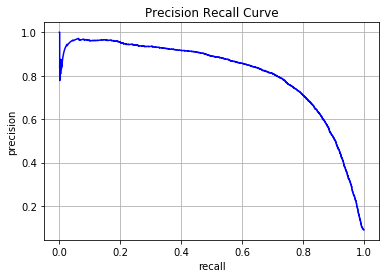

In [23]:
# graph of precision recall curve

def precision_recall_curve(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
    plt.title('Precision Recall Curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.grid()
    
precision_recall_curve(precisions, recalls)

In [24]:
# purpose our goal is precision >= 0.9
# np.argmax means maximum value's first index

threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [25]:
threshold_90_precision

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [29]:
# roc(receiver operating characteristic) curve is usually used in binary classification
# x is FPR(False Positive Rate) and y is TPR(True Positive Rate)
# FPR is 1- TNR(True Negative Rate) = 1 - specificity
# we can use roc_curve function to draw roc curve

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

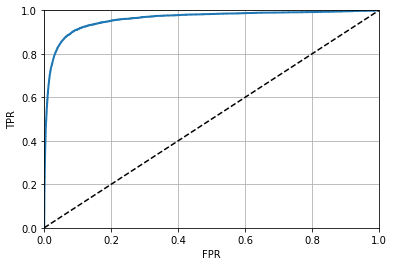

In [30]:
# draw roc curve
# in this case, there are trade off too
# if TPR is higher then FPR is increasing
# dotted line in graph, it means randomized classigier's roc curve
# best model is far away from dotted line(curve is neer by upper left)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
# auc(area under the curve) can be compare classifier
# perfect model's auc is 1, Completely random model's auc is 0.5
# sklearn offer calculate auc

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
# because ROC curve is similar with Precision/Recall curve, we confused which curve we have to use.
# general case, when positive class is few or false positive is more important than false negative  we use Precision/Recall curve. else we use ROC curve
# in above case we think that this is very good model but it because negative class count is much more than positive class count.

In [33]:
# we have to compare ROC curve and QUC score SGDClassifier and RandomforestClassifier
# RandomForestClassifier doesn't have decision_function so we have to use predict_proba()
# in general in sklearn classifier, they have one or all of these methods.
# predict_proba returns row is sample, col is  class, value is probability of each sample belong each class

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
# roc_curve method need label and score
# we use class probabily instead of score

y_scores_foest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_foest)

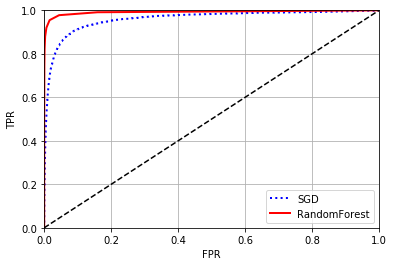

In [35]:
# below graph shows random forest is better than sgd
plt.plot(fpr,tpr,'b:', linewidth=2, label='SGD')
plt.plot(fpr_forest,tpr_forest,'r',linewidth=2, label="RandomForest")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.grid()

In [36]:
# auc also show random forest is better than sgd
roc_auc_score(y_train_5, y_scores_foest)

0.9920527492698306

In [37]:
# precision and recall score also better than sgd
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict')
print('precision >> ' ,precision_score(y_train_5,y_pred_forest))
print('recall >> ', recall_score(y_train_5, y_pred_forest))

/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


precision >>  0.986046511627907
recall >>  0.8212506917542889


In [ ]:
# multiclass classifier

# some algorithm can be handled directly multiclass (SGD, random forest, naive bayes), but another algorithm can only handled binary class
# but by using multiple binary classifier, we can classfy multiclass

# for example in MNIST, by using 10 binary classifiers(some digit or not), we can make classification system in multiclass
# in image classification, we can choose class which get highest score in each decision score
# we call that OvR(one versus the rest) or OvA(one versus all) strategy

# another strategy is training  binary classifier in each numbers combination like seperating 0 and 1, seperating 0 and 2, seperating 1 and 2, etc .
# it calls OvO(one versus one) strategy

# if class is n we need n*(n-1)/2 classifier(in mnist, we need 45 classifier)
# OvO strategy's merit is  training of each classifier only requires samples of two classes to distinguish among the entire training set.

# some algorithm(SVM) is sensitive about training set size, so they prefer OvO
# but almost binary classifier prefer OvR

# in multiclass class classification, if we choose binary algorithm in sklearn, then it automately run OvR or OvO

# below is test of SVM
# it takes lots of time (svc is so slow)
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/Users/hh/opt/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [ ]:
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm.clf.classes_

In [ ]:
svm.clf.classes_[5]

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit